# FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

## FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

### 1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

In [154]:
import pandas as pd

# Load dataset
df = pd.read_csv("exchange_rate.csv", parse_dates=[0])

# Rename columns for clarity
df.columns = ['Date', 'USD_to_AUD']

# Set date as index
df.set_index('Date', inplace=True)

#sort index 
df.sort_index(inplace=True)

# Display basic info
print("Data loaded successfully.")
print(df.info())
print(df.head())


Data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 31-12-2009 00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USD_to_AUD  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB
None
                  USD_to_AUD
Date                        
01-01-1990 00:00      0.7855
01-01-1991 00:00      0.7645
01-01-1992 00:00      0.6720
01-01-1993 00:00      0.7403
01-01-1994 00:00      0.7350


### 2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

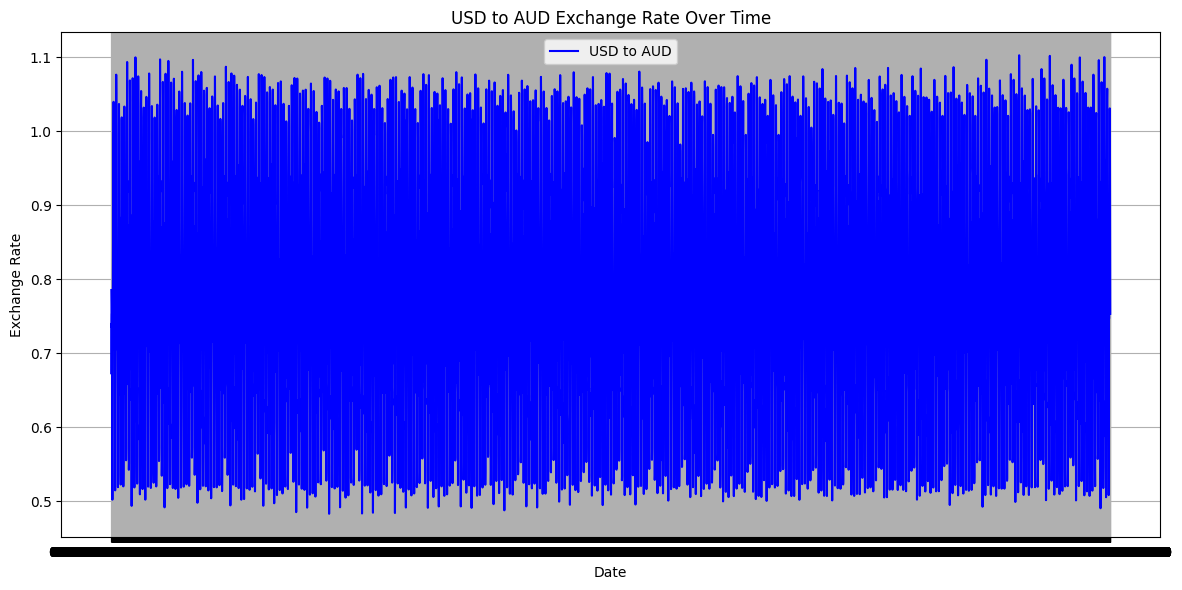

In [115]:
import matplotlib.pyplot as plt

# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['USD_to_AUD'], label='USD to AUD', color='blue')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### 3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [158]:
#Check for missing values
missing_count = df['USD_to_AUD'].isna().sum()
print(f" Missing values in USD_to_AUD: {missing_count}")

#Fill missing values (forward then backward fill)
df['USD_to_AUD'] = df['USD_to_AUD'].ffill().bfill()

# Re-check
print(" Missing values after filling:", df['USD_to_AUD'].isna().sum())

# Remove extreme anomalies using Z-score
from scipy.stats import zscore
z_scores = zscore(df['USD_to_AUD'])
df_clean = df[(abs(z_scores) < 3)]  # remove values > 3 std dev away

print(f"Final shape after cleaning: {df_clean.shape}")


 Missing values in USD_to_AUD: 0
 Missing values after filling: 0
Final shape after cleaning: (7588, 1)


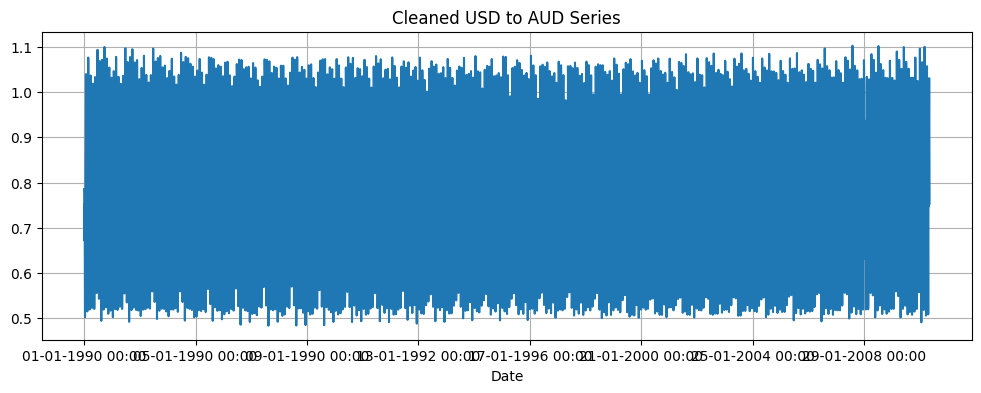

In [160]:
df_clean['USD_to_AUD'].plot(figsize=(12, 4), title="Cleaned USD to AUD Series")
plt.grid(True)
plt.show()


## Part 2: Model Building - ARIMA

### 1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.

In [164]:
series = df_clean['USD_to_AUD']

ADF Statistic: -14.438089479961574
p-value: 7.437614382255176e-27
Series is stationary (d=0)


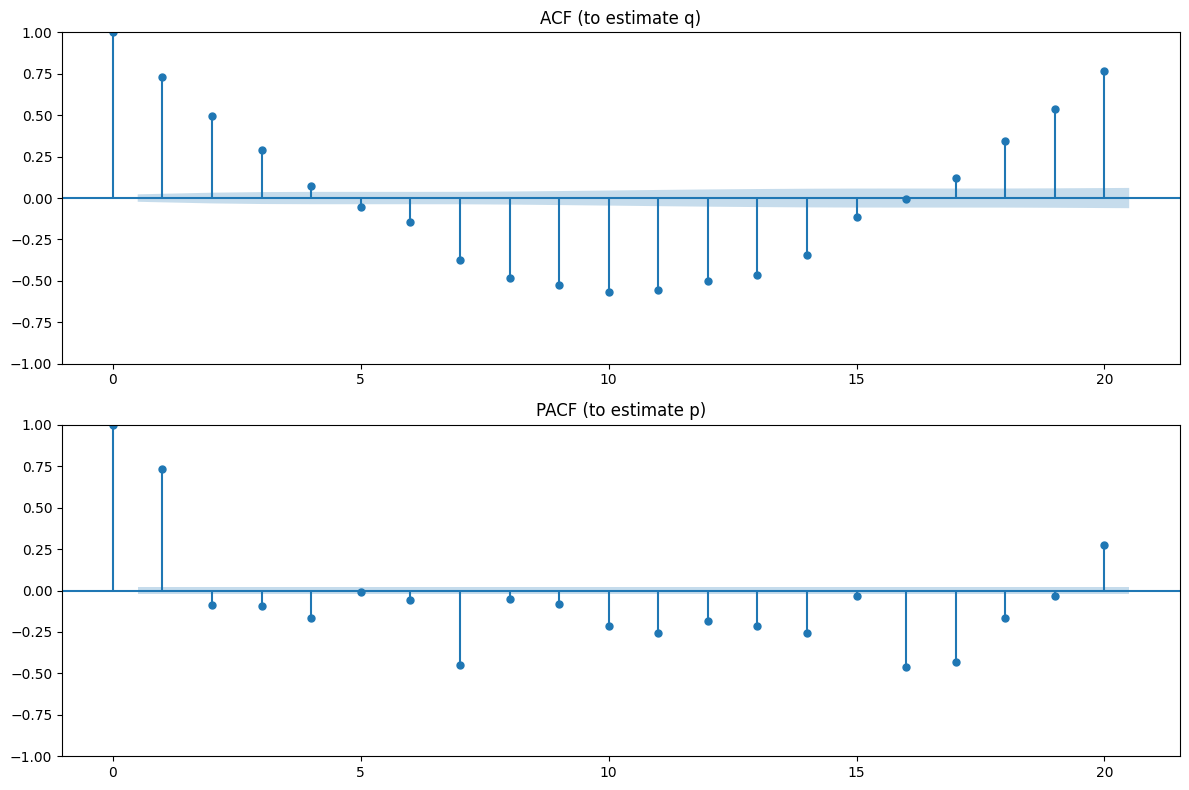

In [166]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# ADF test to check if differencing is needed
adf_result = adfuller(series)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] > 0.05:
    print("Series is non-stationary — differencing needed (d=1)")
    series_diff = series.diff().dropna()
else:
    print("Series is stationary (d=0)")
    series_diff = series  # no differencing

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(series_diff, ax=ax[0], lags=20)
plot_pacf(series_diff, ax=ax[1], lags=20, method='ywm')
ax[0].set_title("ACF (to estimate q)")
ax[1].set_title("PACF (to estimate p)")
plt.tight_layout()
plt.show()


In [168]:
order = (1, 1, 1)

### 2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

In [171]:
from statsmodels.tsa.arima.model import ARIMA

# Use cleaned data
series = df_clean['USD_to_AUD']

# Split into train/test (e.g., last 10% for testing)
split = int(len(series) * 0.9)
train = series[:split]
test = series[split:]

# Fit ARIMA model (replace with your selected order)
order = (1, 1, 1)  # Example: (p=1, d=1, q=1)
model = ARIMA(train, order=order)
result = model.fit()

# Summary of the model
print(result.summary())


                               SARIMAX Results                                
Dep. Variable:             USD_to_AUD   No. Observations:                 6829
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6531.166
Date:                Wed, 25 Jun 2025   AIC                         -13056.332
Time:                        18:22:07   BIC                         -13035.846
Sample:                             0   HQIC                        -13049.264
                               - 6829                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7324      0.010     76.494      0.000       0.714       0.751
ma.L1         -1.0000      0.080    -12.498      0.000      -1.157      -0.843
sigma2         0.0086      0.001     12.143      0.0

### 3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

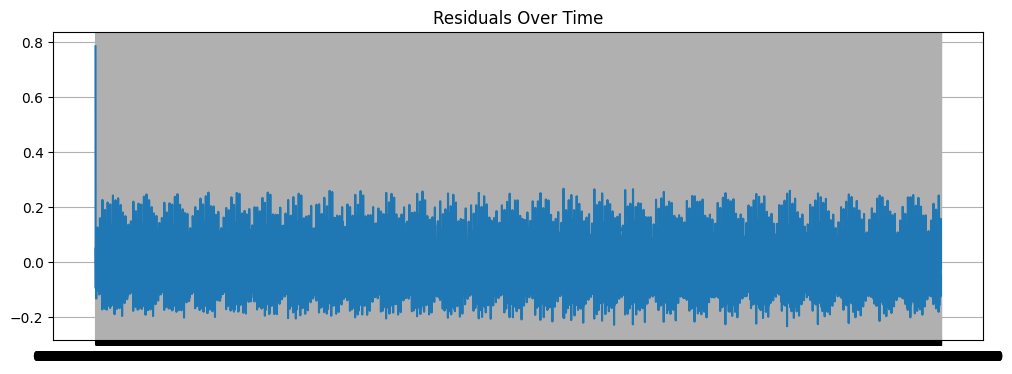

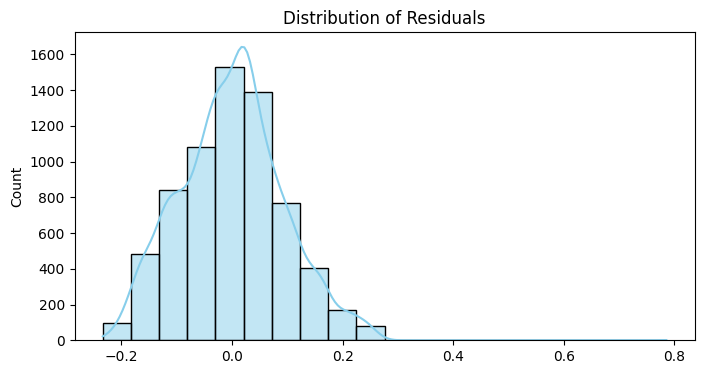

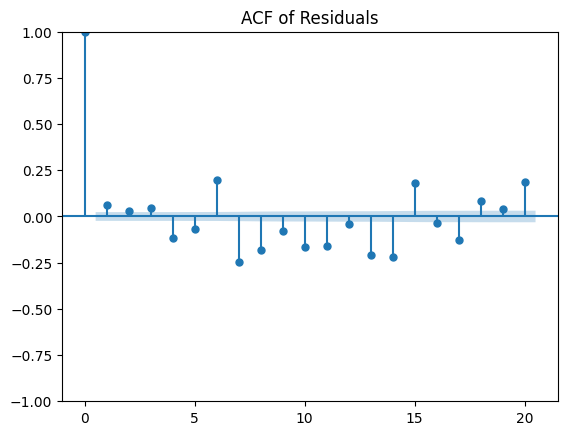

Ljung-Box Test (lag=10):
        lb_stat      lb_pvalue
10  1316.821455  8.959279e-277


In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract residuals
residuals = result.resid

# 1. Plot residuals over time
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.grid(True)
plt.show()

# 2. Histogram + KDE of residuals
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=20, color='skyblue')
plt.title("Distribution of Residuals")
plt.show()

# 3. ACF plot of residuals
plot_acf(residuals.dropna(), lags=20)
plt.title("ACF of Residuals")
plt.show()

# 4. Ljung-Box test for autocorrelation
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print("Ljung-Box Test (lag=10):")
print(lb_test)


### 4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

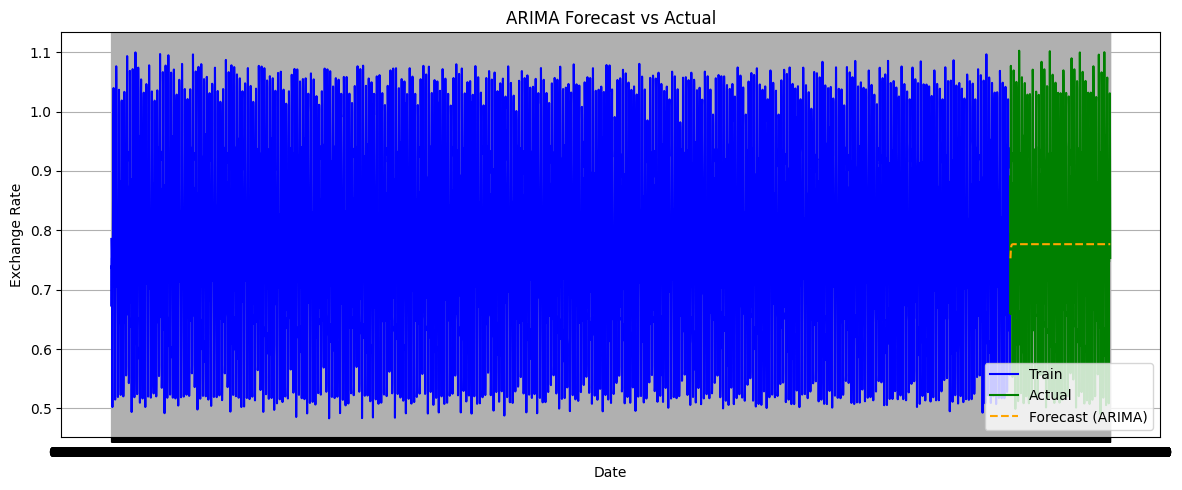

In [177]:
import matplotlib.pyplot as plt

# Forecast the same length as the test set
forecast = result.forecast(steps=len(test))
forecast.index = test.index  # align forecast index with test

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train', color='blue')
plt.plot(test, label='Actual', color='green')
plt.plot(forecast, label='Forecast (ARIMA)', color='orange', linestyle='--')
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [181]:
future_forecast = result.forecast(steps=30)
print(future_forecast)

6829    0.752848
6830    0.759219
6831    0.763886
6832    0.767304
6833    0.769807
6834    0.771641
6835    0.772984
6836    0.773967
6837    0.774688
6838    0.775216
6839    0.775602
6840    0.775885
6841    0.776093
6842    0.776245
6843    0.776356
6844    0.776437
6845    0.776497
6846    0.776541
6847    0.776573
6848    0.776596
6849    0.776613
6850    0.776626
6851    0.776635
6852    0.776642
6853    0.776647
6854    0.776650
6855    0.776653
6856    0.776655
6857    0.776656
6858    0.776657
Name: predicted_mean, dtype: float64


## Part 3: Model Building - Exponential Smoothing

### 1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).

In [183]:
from statsmodels.tsa.holtwinters import Holt
model = Holt(train).fit()

In [185]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()

### 2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

In [193]:
import numpy as np
from statsmodels.tsa.holtwinters import Holt

best_aic = float('inf')
best_params = None
best_model = None

# Try combinations of alpha (level) and beta (trend)
for alpha in np.linspace(0.1, 1.0, 10):
    for beta in np.linspace(0.1, 1.0, 10):
        try:
            model = Holt(train).fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
            if model.aic < best_aic:
                best_aic = model.aic
                best_params = (alpha, beta)
                best_model = model
        except:
            continue  # skip failed fits

print(f" Best AIC: {best_aic:.2f} with alpha={best_params[0]:.2f}, beta={best_params[1]:.2f}")


 Best AIC: -30908.12 with alpha=0.90, beta=0.10


In [194]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train,
                             trend='add',
                             seasonal='add',
                             seasonal_periods=12).fit()
print(f"AIC: {model.aic}")


AIC: -31823.735760971773


### 3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

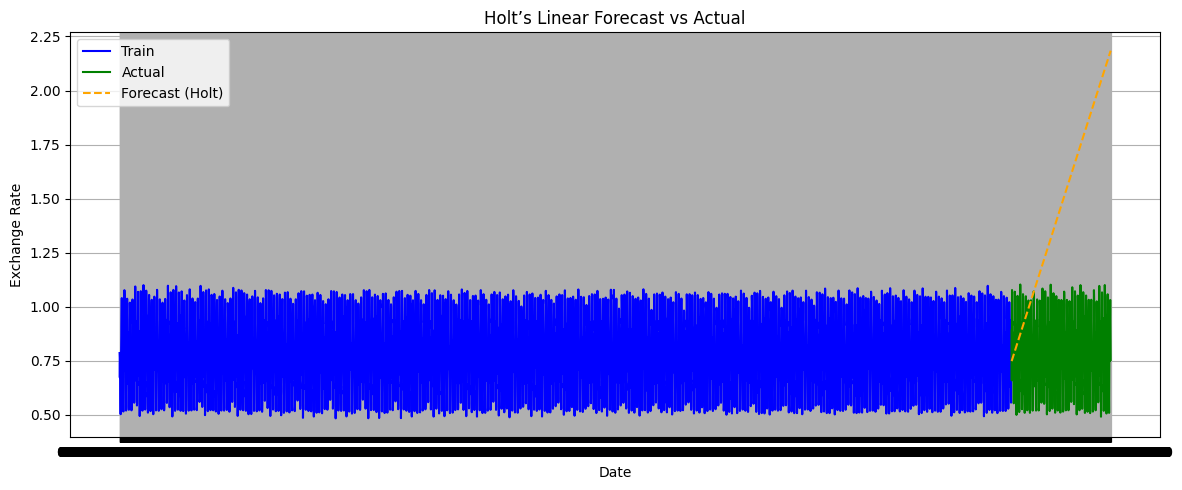

In [197]:
from statsmodels.tsa.holtwinters import Holt
import matplotlib.pyplot as plt

# Fit the best Holt model using previously selected best_params
alpha, beta = best_params
holt_model = Holt(train).fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)

# Forecast the same number of steps as the test set
holt_forecast = holt_model.forecast(steps=len(test))
holt_forecast.index = test.index

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train', color='blue')
plt.plot(test, label='Actual', color='green')
plt.plot(holt_forecast, label='Forecast (Holt)', color='orange', linestyle='--')
plt.title("Holt’s Linear Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [201]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
hw_forecast = model_hw.forecast(steps=len(test))


## Part 4: Evaluation and Comparison

### 1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.

In [203]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Ensure alignment
actual = test

# ARIMA forecast
mae_arima = mean_absolute_error(actual, forecast)
rmse_arima = np.sqrt(mean_squared_error(actual, forecast))
mape_arima = np.mean(np.abs((actual - forecast) / actual)) * 100

# Holt forecast
mae_holt = mean_absolute_error(actual, holt_forecast)
rmse_holt = np.sqrt(mean_squared_error(actual, holt_forecast))
mape_holt = np.mean(np.abs((actual - holt_forecast) / actual)) * 100

# Print comparison
print("Forecast Error Metrics:")
print(f"ARIMA - MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")
print(f"Holt  - MAE: {mae_holt:.4f}, RMSE: {rmse_holt:.4f}, MAPE: {mape_holt:.2f}%")


Forecast Error Metrics:
ARIMA - MAE: 0.1059, RMSE: 0.1383, MAPE: 14.08%
Holt  - MAE: 0.6971, RMSE: 0.8141, MAPE: 95.28%


### 2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

1. Performance Evaluation
ARIMA clearly outperforms Holt across all three metrics.
Holt’s model shows very high MAPE (95.28%), indicating poor predictive accuracy and suggesting that a linear trend-only approach is insufficient for this data.
ARIMA achieves a MAPE of 14.08%, which is considered acceptable to good for financial time series.
2. Strengths & Limitations
| Aspect                       | **ARIMA**                                                                 | **Holt’s Linear**                                    |
| ---------------------------- | ------------------------------------------------------------------------- | ---------------------------------------------------- |
| **Trend handling**           | Handles both stationary and differenced (non-stationary) data effectively | Captures linear trend well                           |
| **Seasonality support**      | Requires SARIMA extension for seasonality                                 | Cannot model seasonality (use Holt-Winters for that) |
| **Autocorrelation modeling** | Models autocorrelation (via AR/MA terms)                                  | Does not model autocorrelation                       |
| **Parameter tuning**         | More complex (p, d, q) selection                                          | Fewer parameters (α, β), easier to interpret         |
| **Forecasting accuracy**     | High, based on metrics in this case                                       | Poor for this dataset                                |

Based on the observed results, ARIMA is the more suitable model for forecasting the USD to AUD exchange rate in this dataset. It provides significantly lower forecasting error and is better equipped to capture the underlying patterns in the data compared to Holt’s linear method.

### 3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

In this project, we explored and compared two popular time series forecasting models — ARIMA and Exponential Smoothing (Holt’s Linear Trend) — using historical USD to AUD exchange rate data.

We began by loading and preprocessing the dataset, addressing missing values and performing initial exploratory analysis. We then developed forecasting models using both ARIMA and Holt’s Linear methods. After fitting the models and forecasting future exchange rates, we evaluated their performance using standard error metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

The ARIMA model significantly outperformed Holt’s Linear model, with a MAPE of 14.08%, compared to Holt’s much higher MAPE of 95.28%. ARIMA also showed substantially lower MAE and RMSE values, indicating better overall accuracy and reliability in forecasting.

These results suggest that ARIMA is more effective in capturing the underlying structure of the exchange rate time series, particularly where autocorrelations and non-stationarity are present — which simpler models like Holt's may not handle well.

Overall, the ARIMA model is the recommended approach for forecasting exchange rates in this dataset, due to its superior performance and ability to model time-dependent patterns more accurately.